In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import tqdm
from collections import namedtuple

## Functions

In [3]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [4]:
def prgroup(grdf, ng=1):
    i = 1
    for name, group in grdf:
        print(f"Group: {name}")
        print(group, "\n")
        i+=1
        if i > ng:
            break

In [5]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [6]:
def event_size(df):
    return len(np.unique(df.event_id))

In [7]:
def xindex(x,sx):
    return np.floor((x + xmin +dx)/sx)

def yindex(x, sy):
    return np.floor((x + ymin +dy)/sy)

def zindex(x, sz):
    return np.floor((x - zmin)/sz)


In [8]:
def voxelize(gdfx,mcrst,sx,sy,sz,ecut,case='pixel'):
    gdf = gdfx.copy()
    nx = int(mcrst.dx/sx)
    ny = int(mcrst.dy/sy)
    nz = int(mcrst.dz/sz)
    
    print(f"nx = {nx}, ny = {ny}, nz = {nz}")
    print(f"number of voxels = {nx*ny*nz}")
    print(f"index for xmin ={xindex(mcrst.xmin, sx)} index for xmax ={xindex(mcrst.xmax, sx)}")
    print(f"index for ymin ={yindex(mcrst.ymin, sy)} index for ymax ={yindex(mcrst.ymax, sy)}")
    print(f"index for zmin ={zindex(mcrst.zmin, sz)} index for zmax ={zindex(mcrst.zmax, sz)}")

    gdf["ix"]= xindex(gdf.final_x.values, sx).astype(int)
    gdf["iy"]= yindex(gdf.final_y.values, sy).astype(int)
    gdf["iz"]= zindex(gdf.final_z.values, sz).astype(int)

    if case == 'pixel':
        grdf = gdf.groupby(['event_id', 'ix', 'iy'])
    else:
         grdf = gdf.groupby(['event_id', 'ix', 'iy', 'iz'])

    gdf = grdf.agg(
                ebox = ('kin_energy', 'sum'),
                tbox = ('initial_t', 'mean'),     
                xbox = ('final_x', 'mean'),     
                ybox = ('final_y', 'mean'),        
                zbox = ('final_z', 'mean'),        # z in the box is the y mean
                nbox = ('final_z', 'count'),
                  ).reset_index()
    
    return gdf

In [9]:
def pixelated(gdfx,mcrst,sx,sy,sz, ecut, case='pixel'):
    gdf = voxelize(gdfx,mcrst,sx,sy,sz, ecut)
    gdf =gdf[gdf.ebox >ecut]
    return event_size(gdf)

In [10]:
def streams(gdx):
    gdf  = gdx.copy()
    grdf = gdf.groupby('event_id')
    gdf  = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                ngama = ('ebox', 'count')
                  ).reset_index()

    df1g = gdf[gdf.ngama==1]
    df2g = gdf[gdf.ngama==2]
    dfng = gdf[gdf.ngama>2]
    print(f" fraction of events 1g = {(event_size(df1g)/event_size(gdf)):.2f}")
    print(f" fraction of events 2g = {(event_size(df2g)/event_size(gdf)):.2f}")
    print(f" fraction of events >3g = {(event_size(dfng)/event_size(gdf)):.2f}")
    return df1g,df2g,dfng
   

## Globals

In [12]:
path_to_data="/Users/jjgomezcadenas/Data/monolith/GammaMonolithicTest"

In [13]:
npr=10
eth = 0.001 # in keV
lmax = 100 # in mm

## Code

In [14]:
file = os.path.join(path_to_data,"GammaMonolithicTestLYSO.h5")

In [15]:
gammas = pd.read_hdf(file,"MC/particles")

In [16]:
gdf0 = gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)
gdf0.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,0,2,e-,0,1,-17.736462,5.652053,21.712429,0.067101,-17.727257,5.603767,21.704294,CRYSTAL,CRYSTAL,0.168159,0.093784,compt
1,0,5226,e-,0,1,-19.781847,3.622597,23.365273,0.078182,-19.781851,3.622591,23.365282,CRYSTAL,CRYSTAL,0.001562,0.000037,compt
2,0,5224,e-,0,1,-19.781847,3.622597,23.365273,0.078182,-19.782503,3.619249,23.365572,CRYSTAL,CRYSTAL,0.037550,0.007724,compt
3,0,1,gamma,1,0,-17.736462,5.652053,1.595947,0.000000,-5963.860352,5578.824219,12500.000000,LAB,WORLD,0.511000,14939.466797,none
4,0,6432,e-,0,1,-20.389175,-10.668499,35.933144,0.141695,-20.373371,-10.711304,35.938786,PLASTIC,PLASTIC,0.090190,0.109963,compt
5,1,4,e-,0,1,8.705390,-3.331151,17.369074,0.056303,8.662795,-3.356666,17.414925,CRYSTAL,CRYSTAL,0.213933,0.103967,compt
6,1,2,e-,0,1,9.596943,-2.401788,16.405571,0.050938,9.594575,-2.424376,16.394161,CRYSTAL,CRYSTAL,0.144989,0.059437,compt
7,1,1,gamma,1,0,9.596943,-2.401788,1.134603,0.000000,8.988111,-2.749416,16.631422,LAB,CRYSTAL,0.511000,17.860416,none
8,1,11016,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988111,-2.749409,16.631411,CRYSTAL,CRYSTAL,0.001563,0.000039,phot
9,1,11013,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988115,-2.749470,16.631447,CRYSTAL,CRYSTAL,0.005211,0.000261,phot


### Select events in which gammas interact in crystal 

In [17]:
filter_gammas_in_crystal = True

In [18]:
if filter_gammas_in_crystal:
    grdf = gdf0.groupby('event_id')
    gdf1 = grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )
else:
    gdf1 = gdf0

In [19]:
gdf1.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
5,1,4,e-,0,1,8.705390,-3.331151,17.369074,0.056303,8.662795,-3.356666,17.414925,CRYSTAL,CRYSTAL,0.213933,0.103967,compt
6,1,2,e-,0,1,9.596943,-2.401788,16.405571,0.050938,9.594575,-2.424376,16.394161,CRYSTAL,CRYSTAL,0.144989,0.059437,compt
7,1,1,gamma,1,0,9.596943,-2.401788,1.134603,0.000000,8.988111,-2.749416,16.631422,LAB,CRYSTAL,0.511000,17.860416,none
8,1,11016,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988111,-2.749409,16.631411,CRYSTAL,CRYSTAL,0.001563,0.000039,phot
9,1,11013,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988115,-2.749470,16.631447,CRYSTAL,CRYSTAL,0.005211,0.000261,phot
10,1,11012,gamma,0,1,8.988111,-2.749416,16.631422,0.059576,8.953529,-2.754367,16.600834,CRYSTAL,CRYSTAL,0.054199,0.046433,phot
11,1,11282,e-,0,11012,8.953529,-2.754367,16.600834,0.059731,8.953523,-2.754359,16.600838,CRYSTAL,CRYSTAL,0.001613,0.000039,phot
12,1,11281,gamma,0,11012,8.953529,-2.754367,16.600834,0.059731,8.923234,-2.771947,16.626619,CRYSTAL,CRYSTAL,0.014918,0.043494,phot
13,1,11356,e-,0,11281,8.923234,-2.771947,16.626619,0.059876,8.923234,-2.771944,16.626616,CRYSTAL,CRYSTAL,0.001031,0.000020,phot
14,1,11354,e-,0,11281,8.923234,-2.771947,16.626619,0.059876,8.922909,-2.771997,16.626190,CRYSTAL,CRYSTAL,0.012886,0.001310,phot


In [20]:
event_size(gdf1)/event_size(gdf0)

0.774217042971595

### Remove primary gammas from dataframe

In [21]:
gdf2 = gdf1[gdf1['mother_id'] != 0]
gdf2.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
5,1,4,e-,0,1,8.705390,-3.331151,17.369074,0.056303,8.662795,-3.356666,17.414925,CRYSTAL,CRYSTAL,0.213933,0.103967,compt
6,1,2,e-,0,1,9.596943,-2.401788,16.405571,0.050938,9.594575,-2.424376,16.394161,CRYSTAL,CRYSTAL,0.144989,0.059437,compt
8,1,11016,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988111,-2.749409,16.631411,CRYSTAL,CRYSTAL,0.001563,0.000039,phot
9,1,11013,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988115,-2.749470,16.631447,CRYSTAL,CRYSTAL,0.005211,0.000261,phot
10,1,11012,gamma,0,1,8.988111,-2.749416,16.631422,0.059576,8.953529,-2.754367,16.600834,CRYSTAL,CRYSTAL,0.054199,0.046433,phot
11,1,11282,e-,0,11012,8.953529,-2.754367,16.600834,0.059731,8.953523,-2.754359,16.600838,CRYSTAL,CRYSTAL,0.001613,0.000039,phot
12,1,11281,gamma,0,11012,8.953529,-2.754367,16.600834,0.059731,8.923234,-2.771947,16.626619,CRYSTAL,CRYSTAL,0.014918,0.043494,phot
13,1,11356,e-,0,11281,8.923234,-2.771947,16.626619,0.059876,8.923234,-2.771944,16.626616,CRYSTAL,CRYSTAL,0.001031,0.000020,phot
14,1,11354,e-,0,11281,8.923234,-2.771947,16.626619,0.059876,8.922909,-2.771997,16.626190,CRYSTAL,CRYSTAL,0.012886,0.001310,phot
15,1,11280,e-,0,11012,8.953529,-2.754367,16.600834,0.059731,8.954237,-2.754041,16.599730,CRYSTAL,CRYSTAL,0.037158,0.002029,phot


In [22]:
event_size(gdf2)/event_size(gdf0)

0.774217042971595

### Remove particles not coming from primary to avoid double counting in energy deposition

In [23]:
grdf = gdf2.groupby('event_id')
gdf3 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)
gdf3.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,1,4,e-,0,1,8.705390,-3.331151,17.369074,0.056303,8.662795,-3.356666,17.414925,CRYSTAL,CRYSTAL,0.213933,0.103967,compt
1,1,2,e-,0,1,9.596943,-2.401788,16.405571,0.050938,9.594575,-2.424376,16.394161,CRYSTAL,CRYSTAL,0.144989,0.059437,compt
2,1,11016,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988111,-2.749409,16.631411,CRYSTAL,CRYSTAL,0.001563,0.000039,phot
3,1,11013,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988115,-2.749470,16.631447,CRYSTAL,CRYSTAL,0.005211,0.000261,phot
4,1,11012,gamma,0,1,8.988111,-2.749416,16.631422,0.059576,8.953529,-2.754367,16.600834,CRYSTAL,CRYSTAL,0.054199,0.046433,phot
5,1,11011,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.993793,-2.746960,16.626230,CRYSTAL,CRYSTAL,0.088709,0.028969,phot
6,2,5,e-,0,1,-5.232054,18.248226,19.223953,0.060195,-5.232061,18.248232,19.223955,CRYSTAL,CRYSTAL,0.001380,0.000031,phot
7,2,4,gamma,0,1,-5.232054,18.248226,19.223953,0.060195,-5.232279,18.253403,19.219248,CRYSTAL,CRYSTAL,0.007645,0.006999,phot
8,2,3,gamma,0,1,-5.232054,18.248226,19.223953,0.060195,-5.054357,18.406935,19.164869,CRYSTAL,CRYSTAL,0.054199,0.245470,phot
9,2,2,e-,0,1,-5.232054,18.248226,19.223953,0.060195,-5.208159,18.208172,19.238409,CRYSTAL,CRYSTAL,0.447680,0.377230,phot


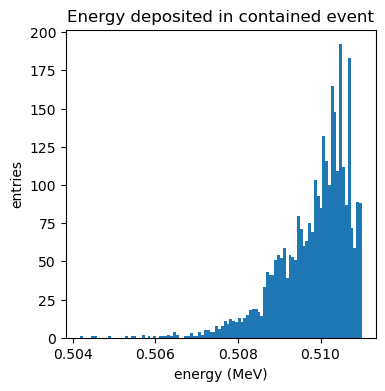

In [24]:
b, e = histoplot(event_ekin(gdf3), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

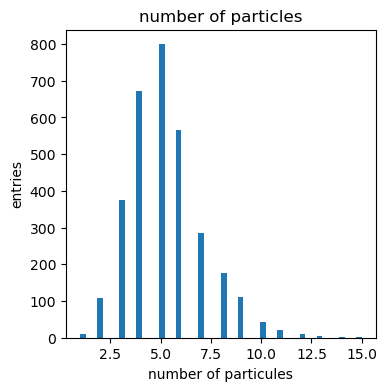

In [25]:
grdf = gdf3.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=50, figsize=(4,4),
                title="number of particles")

## Impose threshold in energy and length

In [26]:
gdf4 = gdf3[(gdf3['kin_energy'] >eth) & (gdf3.length<lmax)]
gdf4.head(npr)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,initial_volume,final_volume,kin_energy,length,creator_proc
0,1,4,e-,0,1,8.705390,-3.331151,17.369074,0.056303,8.662795,-3.356666,17.414925,CRYSTAL,CRYSTAL,0.213933,0.103967,compt
1,1,2,e-,0,1,9.596943,-2.401788,16.405571,0.050938,9.594575,-2.424376,16.394161,CRYSTAL,CRYSTAL,0.144989,0.059437,compt
2,1,11016,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988111,-2.749409,16.631411,CRYSTAL,CRYSTAL,0.001563,0.000039,phot
3,1,11013,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.988115,-2.749470,16.631447,CRYSTAL,CRYSTAL,0.005211,0.000261,phot
4,1,11012,gamma,0,1,8.988111,-2.749416,16.631422,0.059576,8.953529,-2.754367,16.600834,CRYSTAL,CRYSTAL,0.054199,0.046433,phot
5,1,11011,e-,0,1,8.988111,-2.749416,16.631422,0.059576,8.993793,-2.746960,16.626230,CRYSTAL,CRYSTAL,0.088709,0.028969,phot
6,2,5,e-,0,1,-5.232054,18.248226,19.223953,0.060195,-5.232061,18.248232,19.223955,CRYSTAL,CRYSTAL,0.001380,0.000031,phot
7,2,4,gamma,0,1,-5.232054,18.248226,19.223953,0.060195,-5.232279,18.253403,19.219248,CRYSTAL,CRYSTAL,0.007645,0.006999,phot
8,2,3,gamma,0,1,-5.232054,18.248226,19.223953,0.060195,-5.054357,18.406935,19.164869,CRYSTAL,CRYSTAL,0.054199,0.245470,phot
9,2,2,e-,0,1,-5.232054,18.248226,19.223953,0.060195,-5.208159,18.208172,19.238409,CRYSTAL,CRYSTAL,0.447680,0.377230,phot


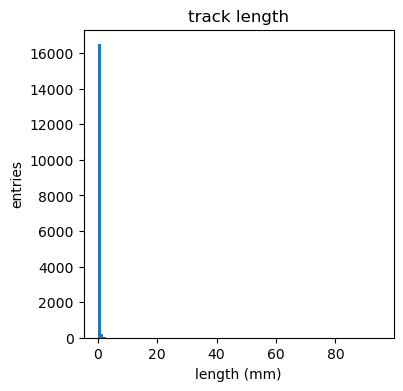

In [27]:
b, e = histoplot(gdf4.length, "length (mm)", "entries", bins=100, figsize=(4,4), title="track length")

### XYZ distributions

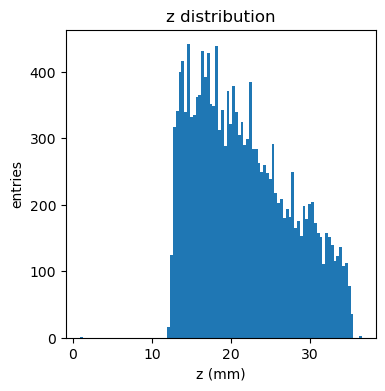

In [28]:
b, e = histoplot(gdf4.initial_z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [29]:
zmin = np.ceil(e[0])
zmax = np.floor(e[-1])
dz = zmax - zmin
print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")

zmax = 36.00, zmin = 1.00, dz = 35.00


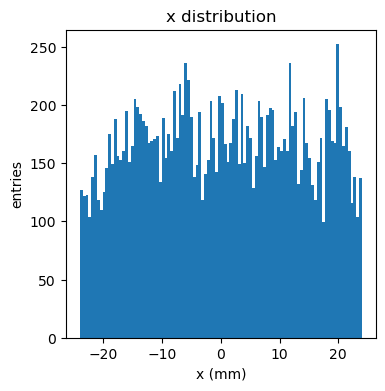

In [30]:
b, e = histoplot(gdf4.initial_x, "x (mm)", "entries", bins=100, figsize=(4,4),
                 title="x distribution")

In [31]:
xmin = -np.ceil(-e[0])
xmax = np.ceil(e[-1])
dx = xmax - xmin
print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")

xmax = 24.00, xmin = -24.00, dx = 48.00


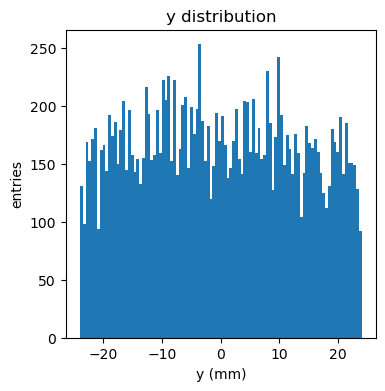

In [32]:
b, e = histoplot(gdf4.initial_y, "y (mm)", "entries", bins=100, figsize=(4,4),
                 title="y distribution")

In [33]:
ymin = -np.ceil(-e[0])
ymax = np.ceil(e[-1])
dy = ymax - ymin
print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")

ymax = 25.00, ymin = -24.00, dy = 49.00


In [34]:
MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
mcrst = MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
mcrst

MCrst(xmin=-24.0, xmax=24.0, dx=48.0, ymin=-24.0, ymax=25.0, dy=49.0, zmin=1.0, zmax=36.0, dz=35.0)

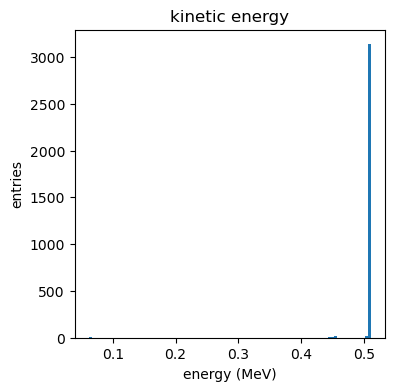

In [35]:
b, e = histoplot(event_ekin(gdf4), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="kinetic energy")

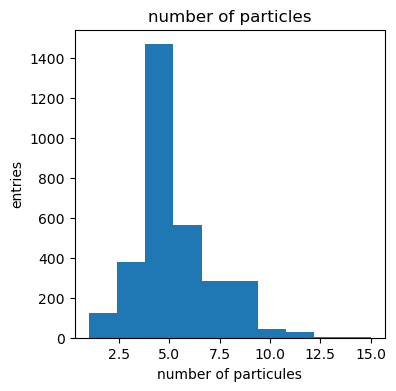

In [36]:
grdf = gdf4.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4,),
                title="number of particles")

In [37]:
fce = event_size(gdf4)/event_size(gdf0)
print(f"Fraction of events contained in crystal = {(fce):.2f}")

Fraction of events contained in crystal = 0.77


In [38]:
gdf5 = gdf4.drop(['initial_x', 'initial_y', 'initial_z', 
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)
gdf5.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,1,4,e-,0.056303,8.662795,-3.356666,17.414925,0.213933,0.103967,compt
1,1,2,e-,0.050938,9.594575,-2.424376,16.394161,0.144989,0.059437,compt
2,1,11016,e-,0.059576,8.988111,-2.749409,16.631411,0.001563,0.000039,phot
3,1,11013,e-,0.059576,8.988115,-2.749470,16.631447,0.005211,0.000261,phot
4,1,11012,gamma,0.059576,8.953529,-2.754367,16.600834,0.054199,0.046433,phot
5,1,11011,e-,0.059576,8.993793,-2.746960,16.626230,0.088709,0.028969,phot
6,2,5,e-,0.060195,-5.232061,18.248232,19.223955,0.001380,0.000031,phot
7,2,4,gamma,0.060195,-5.232279,18.253403,19.219248,0.007645,0.006999,phot
8,2,3,gamma,0.060195,-5.054357,18.406935,19.164869,0.054199,0.245470,phot
9,2,2,e-,0.060195,-5.208159,18.208172,19.238409,0.447680,0.377230,phot


## Classification of events

### Select events in which the primary electron makes a photoelectric

In [39]:
grdf = gdf5.groupby('event_id')
gpe = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'phot')).any() )
gpe.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
6,2,5,e-,0.060195,-5.232061,18.248232,19.223955,0.001380,0.000031,phot
7,2,4,gamma,0.060195,-5.232279,18.253403,19.219248,0.007645,0.006999,phot
8,2,3,gamma,0.060195,-5.054357,18.406935,19.164869,0.054199,0.245470,phot
9,2,2,e-,0.060195,-5.208159,18.208172,19.238409,0.447680,0.377230,phot
10,3,3,gamma,0.053031,-11.068580,9.815348,17.115784,0.063320,0.541973,phot
11,3,2,e-,0.053031,-11.280552,10.129744,16.853889,0.447680,0.311081,phot
12,4,9,e-,0.047706,-13.745811,-19.492638,15.407467,0.001242,0.000027,phot
13,4,6,e-,0.047706,-13.745812,-19.492641,15.407474,0.001380,0.000002,phot
14,4,4,e-,0.047706,-13.745778,-19.492641,15.407516,0.005175,0.000246,phot
15,4,3,gamma,0.047706,-13.755123,-19.482256,15.412704,0.054199,0.014893,phot


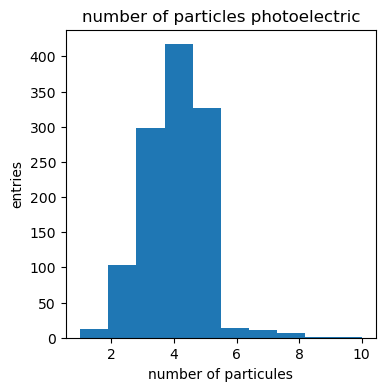

In [40]:
grdf = gpe.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4),
                title="number of particles photoelectric")

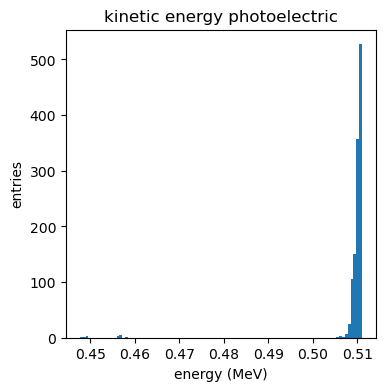

In [41]:
b, e = histoplot(event_ekin(gpe), 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

In [42]:
fphe = event_size(gpe)/event_size(gdf4)
print(f"Fraction of photoelectric events = {(fphe):.2f}")

Fraction of photoelectric events = 0.37


### Select Compton

In [43]:
grdf = gdf5.groupby('event_id')
gcomp = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'compt')).any() )
gcomp.head(npr)

,event_id,particle_id,particle_name,initial_t,final_x,final_y,final_z,kin_energy,length,creator_proc
0,1,4,e-,0.056303,8.662795,-3.356666,17.414925,0.213933,0.103967,compt
1,1,2,e-,0.050938,9.594575,-2.424376,16.394161,0.144989,0.059437,compt
2,1,11016,e-,0.059576,8.988111,-2.749409,16.631411,0.001563,0.000039,phot
3,1,11013,e-,0.059576,8.988115,-2.749470,16.631447,0.005211,0.000261,phot
4,1,11012,gamma,0.059576,8.953529,-2.754367,16.600834,0.054199,0.046433,phot
5,1,11011,e-,0.059576,8.993793,-2.746960,16.626230,0.088709,0.028969,phot
17,5,2,e-,0.082813,13.651561,-2.076695,26.076168,0.323775,0.168859,compt
18,5,9809,e-,0.099732,17.105751,-3.174575,22.865782,0.001242,0.000025,phot
19,5,9807,e-,0.099732,17.102182,-3.178979,22.885118,0.139020,0.065635,phot
20,5,9805,e-,0.098817,16.880596,-3.244008,22.719213,0.045691,0.009809,compt


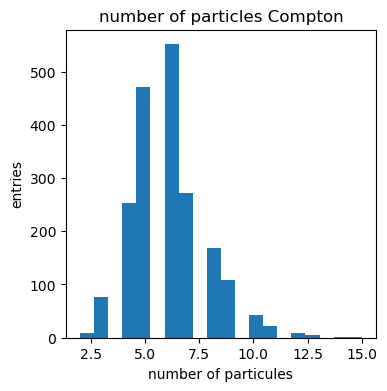

In [44]:
grdf = gcomp.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=20, figsize=(4,4),
                title="number of particles Compton")

In [45]:
fcomp = event_size(gcomp)/event_size(gdf4)
print(f"Fraction of compton events = {(fcomp):.2f}")

Fraction of compton events = 0.62


### Copy dataframe for later

In [46]:
gdx = gdf5.copy(deep=True)
gdy = gdf5.copy(deep=True)

## Case of Pixelated crystal
- Slice x,y in cells corresponding to the size of detector elements (e.g, 3x3 or 6x6)
- no slice in z

### Select events (pixelated case)
- Conditions:
- Energy within 15 % of 511 keV
- 1 pixel lighted

In [51]:
emin = 0.511 - 0.05*0.511
print(f"minimum energy: emin ={emin:.3f}")

minimum energy: emin =0.485


### Comparison between 6x6 and 3x3

In [52]:
npxl3x3 = pixelated(gdy,mcrst,sx=3,sy=3,sz=dz, ecut=emin)

nx = 16, ny = 16, nz = 1
number of voxels = 256
index for xmin =0.0 index for xmax =16.0
index for ymin =0.0 index for ymax =16.0
index for zmin =0.0 index for zmax =1.0


In [53]:
fpxsel3x3 = npxl3x3/event_size(gdf0)
print(f"fraction of selected devents (wrt total events) pixelated 3x3 detector: {(fpxsel3x3):.2f}")

fraction of selected devents (wrt total events) pixelated 3x3 detector: 0.38


In [54]:
npxl6x6 = pixelated(gdy,mcrst,sx=6,sy=6,sz=dz,ecut=emin)

nx = 8, ny = 8, nz = 1
number of voxels = 64
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =1.0


In [55]:
fpxsel6x6 = npxl6x6/event_size(gdf0)
print(f"fraction of selected devents (wrt total events) pixelated 6x6 detector: {(fpxsel6x6):.2f}")

fraction of selected devents (wrt total events) pixelated 6x6 detector: 0.48


## The case of monolithic crystal

- slice in (x,y,z).
- take the size of the slice equal to that of SiPM (e.g, 6x6)

In [56]:
gdm = gdx.copy()

In [57]:
gdm = voxelize(gdm,mcrst,sx=6,sy=6,sz=6,ecut=emin, case='mono')

nx = 8, ny = 8, nz = 5
number of voxels = 320
index for xmin =0.0 index for xmax =8.0
index for ymin =0.0 index for ymax =8.0
index for zmin =0.0 index for zmax =5.0


In [58]:
gdm.head(npr)

,event_id,ix,iy,iz,ebox,tbox,xbox,ybox,zbox,nbox
0,1,5,3,2,0.508604,0.057591,9.030153,-2.796875,16.716501,6
1,2,3,7,3,0.510904,0.060195,-5.181714,18.279186,19.211620,4
2,3,2,5,2,0.511000,0.053031,-11.174566,9.972546,16.984837,2
3,4,1,0,2,0.509675,0.047706,-13.751955,-19.504976,15.438126,5
4,5,6,3,3,0.185953,0.099427,17.029510,-3.199188,22.823372,3
5,5,6,3,4,0.323775,0.082813,13.651561,-2.076695,26.076168,1
6,6,7,4,2,0.510568,0.051200,23.455933,2.826001,16.377981,4
7,7,5,2,4,0.510605,0.085324,11.059227,-12.835720,26.314447,4
8,8,1,1,2,0.249849,0.053719,-12.342299,-16.285847,17.589691,4
9,8,4,2,2,0.259664,0.118008,5.141148,-8.212160,18.207167,5


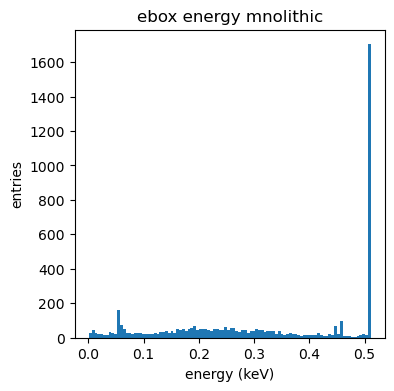

In [59]:
b, e = histoplot(gdm.ebox, "energy (keV)", "entries", bins=100, figsize=(4,4),
                title="ebox energy mnolithic")

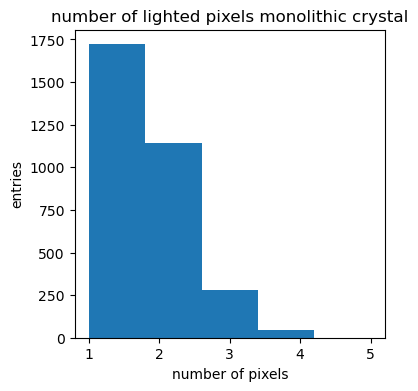

In [60]:
evts, evts_size = np.unique(gdm.event_id.values, return_counts=True)
b, e = histoplot(evts_size, "number of pixels", "entries", bins=5, figsize=(4,4),
                title="number of lighted pixels monolithic crystal") 

In [61]:
f1c = b[0]/np.sum(b)
f2c = b[1]/np.sum(b)
f3c = b[2]/np.sum(b)
print(f"fractions: 1 cluster ={f1c:.2f}")
print(f"fractions: 2 cluster ={f2c:.2f}")
print(f"fractions: 3 cluster ={f3c:.2f}")

fractions: 1 cluster =0.54
fractions: 2 cluster =0.36
fractions: 3 cluster =0.09


## Split data into three streams.
- Stream 1g: events with 1 cluster: true information: x,y,z,t,e
- Stream 2g: events with 2 clusters: true information: x1,y1,z1,t1,e1, x2,y2,z2,t2,e2
- Stream ng: events with more than 2 clusters: no true information needed

#### Strategy:
- First classify events as 1g, 2g or ng. This requires training a CNN with events of categories 1g, 2g, ng.
- Output of the net decides type of event.
- if 1g pass event through a second net trained with events of type 1g and find x,y,z.
- if 2g pass event through a second net trained with events of type 2g and find (x,y,z)_1,2
- if ng reject event

In [62]:
event_size(gdm)/event_size(gdf0)

0.774217042971595

In [63]:
df1g,df2g,dfng = streams(gdm)

 fraction of events 1g = 0.54
 fraction of events 2g = 0.36
 fraction of events >3g = 0.10


In [64]:
gdmx = gdm.drop(['ix', 'iy', 'iz', 
                  'tbox', 'nbox'], axis=1)
gdmx.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,1,0.508604,9.030153,-2.796875,16.716501
1,2,0.510904,-5.181714,18.279186,19.211620
2,3,0.511000,-11.174566,9.972546,16.984837
3,4,0.509675,-13.751955,-19.504976,15.438126
4,5,0.185953,17.029510,-3.199188,22.823372
5,5,0.323775,13.651561,-2.076695,26.076168
6,6,0.510568,23.455933,2.826001,16.377981
7,7,0.510605,11.059227,-12.835720,26.314447
8,8,0.249849,-12.342299,-16.285847,17.589691
9,8,0.259664,5.141148,-8.212160,18.207167


In [65]:
gdm1c = gdmx[gdmx['event_id'].isin(df1g.event_id.values)]
gdm1c.head(npr)

,event_id,ebox,xbox,ybox,zbox
0,1,0.508604,9.030153,-2.796875,16.716501
1,2,0.510904,-5.181714,18.279186,19.211620
2,3,0.511000,-11.174566,9.972546,16.984837
3,4,0.509675,-13.751955,-19.504976,15.438126
6,6,0.510568,23.455933,2.826001,16.377981
7,7,0.510605,11.059227,-12.835720,26.314447
12,11,0.510767,3.354272,21.783991,23.312397
13,12,0.509226,-10.931664,-21.170795,15.901921
14,13,0.509930,19.959013,6.705550,17.302153
15,14,0.509888,23.776724,-22.309952,22.582169


In [66]:
gdm2c = gdmx[gdmx['event_id'].isin(df2g.event_id.values)]
gdm2c.head(npr)

,event_id,ebox,xbox,ybox,zbox
4,5,0.185953,17.029510,-3.199188,22.823372
5,5,0.323775,13.651561,-2.076695,26.076168
8,8,0.249849,-12.342299,-16.285847,17.589691
9,8,0.259664,5.141148,-8.212160,18.207167
10,10,0.327719,-13.684372,-10.494230,17.547371
11,10,0.181736,-6.708357,-9.412413,14.436220
17,17,0.115944,-4.533842,20.119137,12.638059
18,17,0.392878,-2.574203,21.856571,15.033993
23,23,0.248718,12.715295,-13.269074,14.631473
24,23,0.262004,12.772631,-12.676103,14.603542


In [67]:
gdmnc = gdmx[gdmx['event_id'].isin(dfng.event_id.values)]
gdmnc.head(npr)

,event_id,ebox,xbox,ybox,zbox
19,18,0.227472,10.567313,8.021908,14.021614
20,18,0.134556,14.030233,3.152336,18.279945
21,18,0.145987,18.053740,2.771533,15.520790
33,29,0.067332,11.864681,-12.667289,19.004072
34,29,0.232102,14.957991,-14.625475,23.256763
35,29,0.210153,12.111564,-9.435709,17.910103
36,30,0.010032,-2.566490,-4.936744,12.899787
37,30,0.071518,-2.661501,-4.851247,13.572187
38,30,0.426104,9.363766,4.045030,35.130871
40,32,0.158407,-8.841304,4.279702,24.428452


## Two cluster case

In [68]:
grdf = gdm2c.groupby('event_id')
gdy2ca = grdf.agg(#event_id = ('event_id', 'first'),
                etot = ('ebox', 'sum'),
                e1 = ('ebox', 'first'),
                e2 = ('ebox', 'last'),
                x1 = ('xbox', 'first'),
                x2 = ('xbox', 'last'),
                y1 = ('ybox', 'first'),
                y2 = ('ybox', 'last'),
                z1 = ('zbox', 'first'),
                z2 = ('zbox', 'last')
                  ).reset_index()

In [69]:
gdy2ca

,event_id,etot,e1,e2,x1,x2,y1,y2,z1,z2
0,5,0.509728,0.185953,0.323775,17.029510,13.651561,-3.199188,-2.076695,22.823372,26.076168
1,8,0.509512,0.249849,0.259664,-12.342299,5.141148,-16.285847,-8.212160,17.589691,18.207167
2,10,0.509455,0.327719,0.181736,-13.684372,-6.708357,-10.494230,-9.412413,17.547371,14.436220
3,17,0.508822,0.115944,0.392878,-4.533842,-2.574203,20.119137,21.856571,12.638059,15.033993
4,23,0.510722,0.248718,0.262004,12.715295,12.772631,-13.269074,-12.676103,14.631473,14.603542
...,...,...,...,...,...,...,...,...,...,...
1139,4083,0.510234,0.346523,0.163711,-5.514931,-5.094244,-15.095581,-12.734172,13.551453,13.825031
1140,4097,0.511000,0.447680,0.063320,-5.565032,15.441555,1.197703,-18.278105,-19.428343,12.610024
1141,4101,0.509316,0.162533,0.346783,-1.647350,-5.525331,-3.963452,-4.602378,15.177788,21.253796
1142,4106,0.508733,0.074265,0.434468,19.547874,19.235806,14.694715,15.588113,30.481880,32.022186


Text(0, 0.5, 'e2 (mm)')

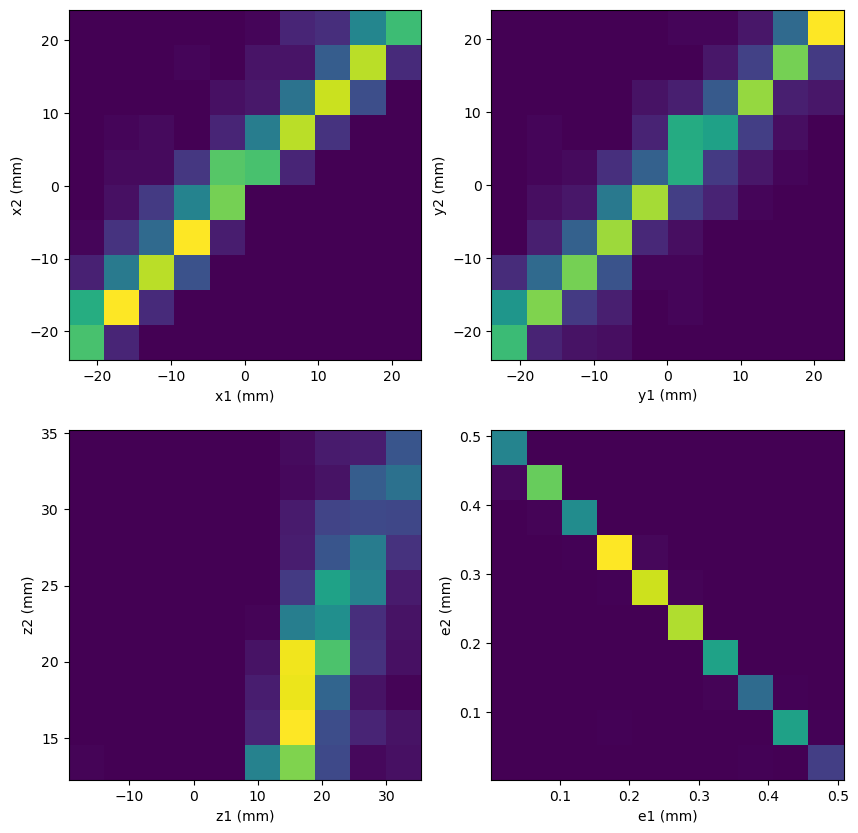

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

hxy =ax[0,0].hist2d(gdy2ca.x1, gdy2ca.x2, cmap="viridis",bins=10)
#ax[0].set_aspect('equal')
ax[0,0].set_xlabel('x1 (mm)')
ax[0,0].set_ylabel('x2 (mm)')

hxz =ax[0,1].hist2d(gdy2ca.y1, gdy2ca.y2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[0,1].set_xlabel('y1 (mm)')
ax[0,1].set_ylabel('y2 (mm)')

hxz =ax[1,0].hist2d(gdy2ca.z1, gdy2ca.z2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,0].set_xlabel('z1 (mm)')
ax[1,0].set_ylabel('z2 (mm)')

hxz =ax[1,1].hist2d(gdy2ca.e1, gdy2ca.e2, cmap="viridis",bins=10)
#ax[1].set_aspect('equal')
ax[1,1].set_xlabel('e1 (mm)')
ax[1,1].set_ylabel('e2 (mm)')